# Detection of Parkinson's disease using handwriting

---
Include libraries


In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Activation
from keras.models import Model
from keras import backend as K
from keras import optimizers
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from IPython.display import display, Image
from sklearn.model_selection import GroupKFold
from evalModel import predict_on_image
import tensorflow as tf

Using TensorFlow backend.


---
load data and define parameters

In [2]:
PATH_HC='C:/Users/elmon/Desktop/work/HandwritingCNN/data/images/hc_image/104_78/'
PATH_PD='C:/Users/elmon/Desktop/work/HandwritingCNN/data/images/pd_image/104_78/'
SIZE_IMAGE=[78,104]
PIXEL_DEPTH=255

FILTER_SIZE_C1=7
FILTER_SIZE_C2=6
DEPTH_C1=4
DEPTH_C2=8
HIDDEN=256
BATCH_SIZE=64
EPOCHS=50

## Prepare data

---
read images



In [3]:
dirhc=os.listdir(PATH_HC)
dirpd=os.listdir(PATH_PD)

dirhc.sort()
dirpd.sort()

imageHC=np.zeros((len(dirhc), SIZE_IMAGE[0], SIZE_IMAGE[1],1))
imagePD=np.zeros((len(dirpd), SIZE_IMAGE[0], SIZE_IMAGE[1],1))

labelsHC=np.vstack((np.zeros(len(dirhc)), np.ones(len(dirhc)))).T
labelsPD=np.vstack((np.ones(len(dirpd)), np.zeros(len(dirpd)))).T

IDHC=np.zeros(len(dirhc))
IDPD=np.zeros(len(dirpd))

for j in range(len(dirhc)):
    image_file=PATH_HC+dirhc[j]
    image_data = (ndimage.imread(image_file).astype(float) - PIXEL_DEPTH / 2) / PIXEL_DEPTH
    image_datagray=image_data.mean(axis=2)
    imageHC[j,:,:,0]=image_datagray
    IDHC[j]=int(dirhc[j][7:10])
    
print(np.unique(IDHC))
    
for j in range(len(dirpd)):
    image_file=PATH_PD+dirpd[j]
    image_data = (ndimage.imread(image_file).astype(float) - PIXEL_DEPTH / 2) / PIXEL_DEPTH
    image_datagray=image_data.mean(axis=2)
    imagePD[j,:,:,0]=image_datagray
    IDPD[j]=int(dirpd[j][4:7])+max(IDHC)
 
    
print(np.unique(IDPD))
print(imageHC.shape)
print(imagePD.shape)
print(labelsHC.shape, labelsPD.shape)


[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.]
[ 41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.]
(679, 78, 104, 1)
(520, 78, 104, 1)
(679, 2) (520, 2)


---
Display some of the images




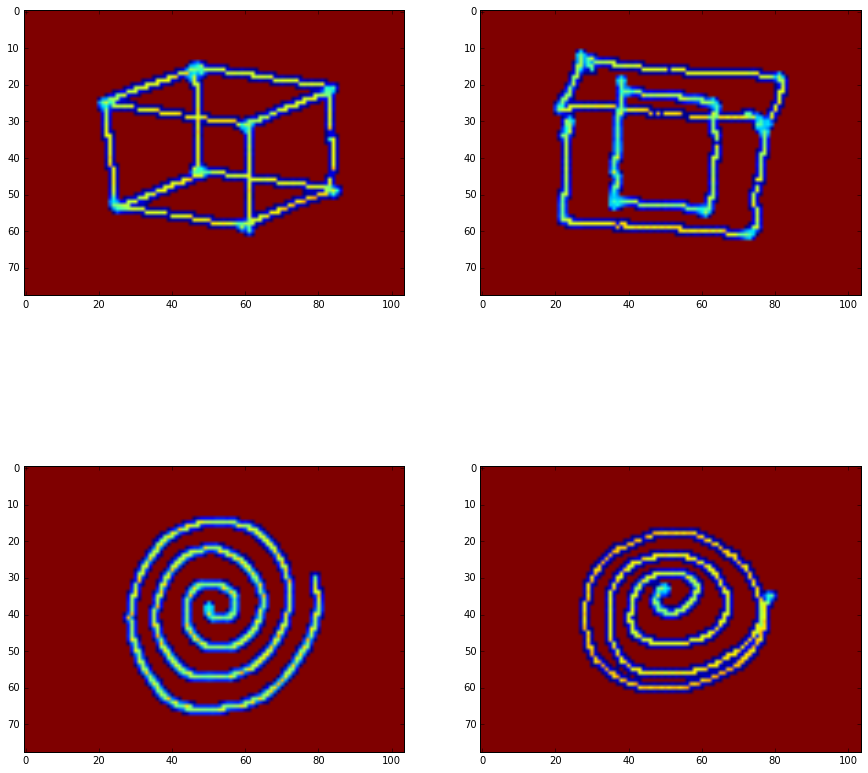

In [4]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(imageHC[4,:,:,0])
plt.subplot(2,2,2)
plt.imshow(imagePD[14,:,:,0])
plt.subplot(2,2,3)
plt.imshow(imageHC[16,:,:,0])
plt.subplot(2,2,4)
plt.imshow(imagePD[50,:,:,0])
plt.show()

---
randomize and stack data for train and test

In [5]:
images_all=np.concatenate((imageHC, imagePD), axis=0)
labels_all=np.vstack((labelsHC, labelsPD))
ID_all=np.hstack((IDHC, IDPD))


def randomize(dataset, labels, ID):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:,:]
    shuffled_labels = labels[permutation,:]
    shuffled_ID=ID[permutation]
    return shuffled_dataset, shuffled_labels, shuffled_ID


dataset, labels, ID=randomize(images_all, labels_all, ID_all)

print(dataset.shape, labels.shape, ID.shape)


gkf = GroupKFold(n_splits=10)
for train, test in gkf.split(dataset, labels, groups=ID):
    print(train.shape, test.shape)
    
x_train=dataset[train,:,:,:]
y_train=labels[train,:]
x_test=dataset[test,:,:,:]
y_test=labels[test,:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(1199, 78, 104, 1) (1199, 2) (1199,)
(1088,) (111,)
(1078,) (121,)
(1079,) (120,)
(1077,) (122,)
(1077,) (122,)
(1077,) (122,)
(1078,) (121,)
(1079,) (120,)
(1079,) (120,)
(1079,) (120,)
(1079, 78, 104, 1) (1079, 2)
(120, 78, 104, 1) (120, 2)


## Define and Train CNN

---
Define the CNN architecture



In [6]:
input_img = Input(shape=(SIZE_IMAGE[0], SIZE_IMAGE[1],1))  # adapt this if using `channels_first` image data format

x = Conv2D(DEPTH_C1, (FILTER_SIZE_C1, FILTER_SIZE_C1), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(DEPTH_C2, (FILTER_SIZE_C2, FILTER_SIZE_C2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
print(x.shape[1]*x.shape[2]*x.shape[3])
x= Reshape((int(x.shape[1]*x.shape[2]*x.shape[3]),))(x)
print(x.shape)
x = Dense(HIDDEN, activation='relu')(x)
x = Dense(2, activation='softmax')(x)
print(x.shape)

CNN = Model(input_img, x)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
CNN.compile(optimizer='sgd', loss='binary_crossentropy')

(?, 20, 26, 8)
4160
(?, 4160)
(?, 2)


---
Train the CNN

In [7]:
from keras.callbacks import TensorBoard

CNN.fit(x_train, y_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/CNN')])
                
                
## tensorboard --logdir='/tmp/CNN'


Train on 1079 samples, validate on 120 samples
Epoch 1/50
1079/1079 [==============================] - 9s - loss: 0.6786 - val_loss: 0.7264
Epoch 2/50
1079/1079 [==============================] - 8s - loss: 0.6718 - val_loss: 0.7236
Epoch 3/50
1079/1079 [==============================] - 8s - loss: 0.6672 - val_loss: 0.7299
Epoch 4/50
1079/1079 [==============================] - 8s - loss: 0.6630 - val_loss: 0.7113
Epoch 5/50
1079/1079 [==============================] - 8s - loss: 0.6605 - val_loss: 0.7187
Epoch 6/50
1079/1079 [==============================] - 8s - loss: 0.6563 - val_loss: 0.7105
Epoch 7/50
1079/1079 [==============================] - 8s - loss: 0.6515 - val_loss: 0.7292
Epoch 8/50
1079/1079 [==============================] - 8s - loss: 0.6482 - val_loss: 0.6994
Epoch 9/50
1079/1079 [==============================] - 8s - loss: 0.6436 - val_loss: 0.7089
Epoch 10/50
1079/1079 [==============================] - 8s - loss: 0.6385 - val_loss: 0.7265
Epoch 11/50
1079/1079 

---
Predict output of the CNN in images from test set

In [8]:
y_pred = CNN.predict(x_test)
print (y_pred.shape)

y_test1=np.argmax(y_test,axis=1)
print(y_test1)
y_pred1=np.argmax(y_pred,axis=1)
print(y_pred1)

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test1, y_pred1))

y_pred = CNN.predict(x_train)
print (y_pred.shape)

y_test1=np.argmax(y_train,axis=1)
y_pred1=np.argmax(y_pred,axis=1)

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test1, y_pred1))


(120, 2)
[0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1
 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0
 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1
 0 1 0 1 0 0 1 1 0]
[0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0
 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0
 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 0 0 1 0 1]
0.641666666667
(1079, 2)
0.833178869323


## Test of some images

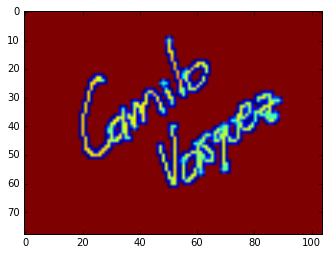

[0]
drawing is detected as patient


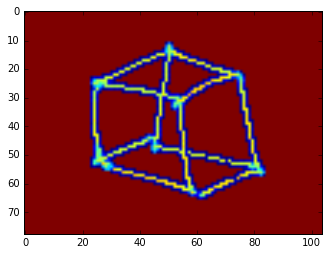

[1]
drawing is detected as healthy


In [9]:
image_file='PDMMHCJ029name.png'
image_data=np.zeros((1, SIZE_IMAGE[0], SIZE_IMAGE[1],1))
image = (ndimage.imread(image_file).astype(float) - PIXEL_DEPTH / 2) / PIXEL_DEPTH
image_data[0,:,:,0]=image.mean(axis=2)
plt.imshow(image_data[0,:,:,0])
plt.show()

y_pred = CNN.predict(image_data)
y_pred=np.argmax(y_pred,axis=1)
print(y_pred)
if y_pred==0:
    print('drawing is detected as patient')
else:
    print('drawing is detected as healthy')
    
    
image_file='PDMMHCJ029cube.png'
image_data=np.zeros((1, SIZE_IMAGE[0], SIZE_IMAGE[1],1))
image = (ndimage.imread(image_file).astype(float) - PIXEL_DEPTH / 2) / PIXEL_DEPTH
image_data[0,:,:,0]=image.mean(axis=2)
plt.imshow(image_data[0,:,:,0])
plt.show()

y_pred = CNN.predict(image_data)
y_pred=np.argmax(y_pred,axis=1)
print(y_pred)
if y_pred==0:
    print('drawing is detected as patient')
else:
    print('drawing is detected as healthy')
    
    
    
    

## Retrain Inception

### Acc=87.6% 4000 steps

[0.717944324016571, 0.28205567598342896]


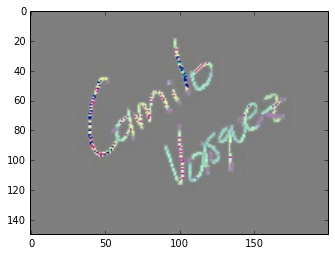

0
drawing is detected as healthy
[0.0026544604916125536, 0.9973456263542175]


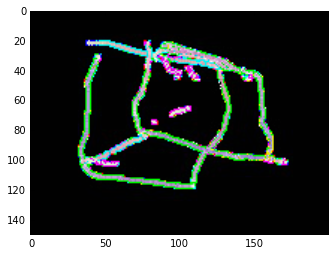

1
drawing is detected as patient
[0.2896824777126312, 0.7103175520896912]


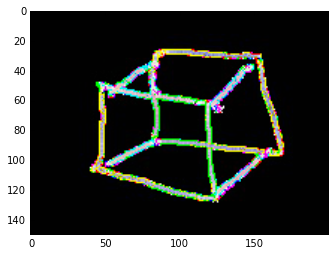

1
drawing is detected as patient


In [11]:
cnn_file='C:/Users/elmon/Desktop/work/HandwritingCNN/re_trainedinception200_150/retrained_graph.pb'
real_labels='C:/Users/elmon/Desktop/work/HandwritingCNN/laball.txt'
image_file='PDMMHCJ029name.jpg'
prediction=predict_on_image(image_file, real_labels, cnn_file)


image = (ndimage.imread(image_file).astype(float) - PIXEL_DEPTH / 2) / PIXEL_DEPTH
plt.imshow(image)
plt.show()


y_pred=np.argmax(prediction)
print(y_pred)
if y_pred==1:
    print('drawing is detected as patient')
else:
    print('drawing is detected as healthy')
   
    
    
image_file='PDMM003cube.jpg'
prediction=predict_on_image(image_file, real_labels, cnn_file)
y_pred=np.argmax(prediction)

image = (ndimage.imread(image_file).astype(float))
plt.imshow(image)
plt.show()

print(y_pred)
if y_pred==1:
    print('drawing is detected as patient')
else:
    print('drawing is detected as healthy')
    
    
image_file='PDMM004cube.jpg'
prediction=predict_on_image(image_file, real_labels, cnn_file)
y_pred=np.argmax(prediction)

image = (ndimage.imread(image_file).astype(float))
plt.imshow(image)
plt.show()

print(y_pred)
if y_pred==1:
    print('drawing is detected as patient')
else:
    print('drawing is detected as healthy')